# Conservative integrals / means on the Yin Yang grid using Goddard weighting

This is an example notebook which illustrates a few things:

1. Reading RPN standard files into python using fstd2nc
2. Plotting data in a map projection on the Yin/Yang grids
3. Computing global means/integrals over the Yin and Yang grids, using the approach of Goddard (2014)

To achieve these, data for the field of interest, the grid cell areas, and the Goddard weights are all required. These are not necessarily all available in one place. What is done here is to use RPN files that have the fields of interest (e.g. BEGO) and the grid cell areas, while the Goddard weights computed inside GEM are read from a separate file. Note that there are multiple different Yin Yang grid sizes in GEM (i.e. how much overlap). Here, everything is being done on the 303x115 grids, also know I believe as "global".

Remapping the Yin Yang individual grids to a single global target grid is a further step, but relies on some of the steps illustrated here.

NCS Feb 2023

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numpy.ma as ma
import fstd2nc
import xesmf as xe

## Load in RPN format data to Xarrays 

Note these files contain CanAM physics data and ancillary fields, including grid cell areas (DX) on the 303x115 grids, and only for a single timestep.

In [90]:
ds_yin_dx =  fstd2nc.Buffer('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/2003010100_00000006_yin',  yin=True).to_xarray()
ds_yan_dx =  fstd2nc.Buffer('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/2003010100_00000006_yan',  yang=True).to_xarray()
vars=["OLR","FSO","FSR","PCP","PCPN","HFS","HFL","QFS","FSG","FLG"]
#ds_yin = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/the_yin_part.fst').to_xarray()
#ds_yin = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_0*.yin').to_xarray()
ds_yan = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_0*.yan',vars=vars).to_xarray()
ds_yin = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_0*.yin',vars=vars).to_xarray()
#ds_yan = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_00008*.yan',vars=vars).to_xarray()

#ds_yan = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/the_yang_part.fst').to_xarray()


Found 1 RPN input file(s)
 E 64  X  5005     0   300  1500
Read(999) !!   X  GCMTEST1            3     105     1  000000000        78348     95724         0        0        0  E 64  X  5005     0   300  1500
Read(999) !!   X  GCMTEST1            3     105     1  000000000        83519     50521         0        0        0  E 64  X  5005     0   300  1500
Read(999) !!   X  GCMTEST1            3     105     1  000000000        78348     95724         0        0        0  E 64  X  5005     0   300  1500
Read(999) !!   X  GCMTEST1            3     105     1  000000000        83519     50521         0        0        0  E 64  X  5005     0   300  1500
Read(999) SV   P  GCMTEST1          303     115     1  304661600            0         6         0     1800       12  f 12  Z 73619 68458     1     0
Read(999) !!   X  GCMTEST1            3     105     1  000000000        78348     95724         0        0        0  E 64  X  5005     0   300  1500
Read(999) !!   X  GCMTEST1            3     105

In [91]:
#vars=["OLR","FSO","FSR","PCP","PCPN","HFS","HFL","QFS","FSG","FLG"]
#ds_yin_time_mean = ds_yin[vars].mean('time')
#ds_yan_time_mean = ds_yan[vars].mean('time')
#print(ds_yan_time_mean)

# Read / plot Goddard weights for a separate file

Note these weights are generally not available in the model output. I had to get the specially output from GEM. Also note, the weights are the same for each grid.

In [92]:
gweights = xr.open_dataset('/home/ncs001/gem-vis/fortran/goddard_weights_yin.nc').weights

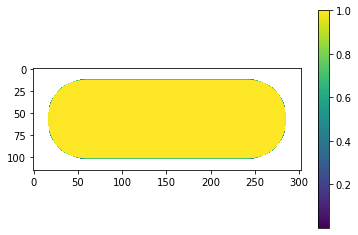

In [93]:
# For convenience in plotting and computing means, set zero values to NaN
gweights_znan = xr.where(gweights.squeeze() ==0, np.NaN, gweights.squeeze()).to_numpy()
plt.imshow(gweights_znan)
plt.colorbar()

## Goddard weighted BEGO

NOTE THE ROUNDED EDGES (overlaps have been eliminated - this is the tennis ball seam)

In [94]:
# Simply mulitply by the weights
#bego_yin_gweighted = ds_yin_time_mean['FSO'].squeeze()*gweights_znan.values
#bego_yan_gweighted = ds_yan_time_mean['FSO'].squeeze()*gweights_znan.values

# Compute the integral / mean of BEGO across YG grids

Compute the global mean for each term in BALX and ABEG

In [96]:
yin_gweighted_area = (ds_yin_dx.DX * gweights_znan).sum().to_numpy()
yan_gweighted_area = (ds_yan_dx.DX * gweights_znan).sum().to_numpy()
yg_gweighted_area = yin_gweighted_area + yan_gweighted_area
ds_yin_dx_area = ds_yin_dx.DX.squeeze().to_numpy()
ds_yan_dx_area = ds_yan_dx.DX.squeeze().to_numpy()

vars=["OLR","FSO","FSR","PCP","PCPN","HFS","HFL","QFS","FSG","FLG"]
#vars=["OLR"]
ds_yin_time_mean=ds_yin[vars].mean('time')
ds_yan_time_mean=ds_yan[vars].mean('time')
print(ds_yin_time_mean)
glob_means={}

for varname in vars:
    print(varname)
    #ds_yin = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_00008*.yin',vars=varname).to_xarray()
    #ds_yan = fstd2nc.Buffer('/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/check_CanAM_GEM_global_means/split_yin_yang/1969010100_00008*.yan',vars=varname).to_xarray()  
    #print('time mean yin')
    #ds_yin_time_mean = ds_yin[varname].mean('time').to_numpy()
    da_yin_time_mean = ds_yin_time_mean[varname].to_numpy()
    #print('time mean yan')
    #ds_yan_time_mean = ds_yan[varname].mean('time').to_numpy()
    da_yan_time_mean = ds_yan_time_mean[varname].to_numpy()

    data_yin_gweighted = da_yin_time_mean*gweights_znan*ds_yin_dx_area
    data_yan_gweighted = da_yan_time_mean*gweights_znan*ds_yin_dx_area

    data_integral = np.nansum(data_yin_gweighted) + np.nansum(data_yan_gweighted)
    data_mean =  data_integral / yg_gweighted_area

    print(varname,data_mean,data_integral,yg_gweighted_area)
    glob_means[varname]=data_mean

<xarray.Dataset>
Dimensions:  (rlat: 115, rlon: 303)
Coordinates:
  * rlat     (rlat) float32 -57.0 -56.0 -55.0 -54.0 ... 54.0 55.0 56.0 57.0
  * rlon     (rlon) float32 -160.5 -159.5 -158.5 -157.5 ... 139.5 140.5 141.5
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
Data variables:
    OLR      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    FSO      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    FSR      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    PCP      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    PCPN     (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    HFS      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    HFL      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    QFS      (rlat, rlon) float32 dask.array<chunksize=(115, 303), meta=np.ndarray>
    FSG      (rl

KeyboardInterrupt: 

In [ ]:
BALX = glob_means['FSO']-glob_means['OLR']-glob_means['FSR']

ABEG = glob_means['FSG']+glob_means['FLG']-glob_means['HFS']

HS=2.835E6
HV=2.501E6

LATA = glob_means['PCPN']*HS \
     + (glob_means['PCP']-glob_means['PCPN'])*HV

ABEG = ABEG - LATA

In [ ]:
print(BALX,ABEG,BALX-ABEG)